# Random Forest regression

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import plot_tree
sb.set()
import re
import tensorflow as tf
import keras as keras
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [2]:
laptop_data_clean = pd.read_csv('./laptop_data_clean.csv', encoding='latin-1')
laptop_data_clean

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_sgd
0,Apple,MacBook Pro,Ultrabook,13.3,2560x1600,Intel Core i5,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,2103.31
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,1411.34
2,HP,250 G6,Notebook,15.6,1920x1080,Intel Core i5,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,902.75
3,Apple,MacBook Pro,Ultrabook,15.4,2880x1800,Intel Core i7,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,3983.80
4,Apple,MacBook Pro,Ultrabook,13.3,2560x1600,Intel Core i5,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,2831.65
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,1920x1080,Intel Core i7,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.80,1001.66
1299,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,3200x1800,Intel Core i7,16,512GB SSD,Intel HD Graphics 520,Windows 10,1.30,2353.43
1300,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Others,2,64GB Flash Storage,Intel HD Graphics,Windows 10,1.50,359.53
1301,HP,15-AC110nv,Notebook,15.6,1366x768,Intel Core i7,6,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19,1199.48


In [3]:
laptop_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   int64  
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   float64
 11  Price_sgd         1303 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 122.3+ KB


# Forest regression using only the top 4 attributes that were selected
> Attributes: ScreenResolution,Cpu,Ram, Gpu and OpSys

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
laptop_data_clean['Company'] = le.fit_transform(laptop_data_clean['Company'])
laptop_data_clean['Product'] = le.fit_transform(laptop_data_clean['Product'])
laptop_data_clean['TypeName'] = le.fit_transform(laptop_data_clean['TypeName'])
#laptop_data_clean['Inches'] = le.fit_transform(laptop_data_clean['Inches'])
laptop_data_clean['ScreenResolution'] = le.fit_transform(laptop_data_clean['ScreenResolution'])
#laptop_data_clean['Ram'] = le.fit_transform(laptop_data_clean['Ram'])
laptop_data_clean['Memory'] = le.fit_transform(laptop_data_clean['Memory'])
laptop_data_clean['Cpu'] = le.fit_transform(laptop_data_clean['Cpu'])
laptop_data_clean['Gpu'] = le.fit_transform(laptop_data_clean['Gpu'])
laptop_data_clean['OpSys'] = le.fit_transform(laptop_data_clean['OpSys'])
#laptop_data_clean['Weight'] = le.fit_transform(laptop_data_clean['Weight'])
#laptop_data_clean['Price_sgd'] = le.fit_transform(laptop_data_clean['Price_sgd'])
laptop_data_clean

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_sgd
0,1,297,4,13.3,10,2,8,4,58,8,1.37,2103.31
1,1,298,4,13.3,1,2,8,2,51,8,1.34,1411.34
2,7,50,3,15.6,3,2,8,16,53,4,1.86,902.75
3,1,297,4,15.4,12,3,16,29,9,8,1.83,3983.80
4,1,297,4,13.3,10,2,8,16,59,8,1.37,2831.65
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,10,555,0,14.0,3,3,4,4,47,5,1.80,1001.66
1299,10,563,0,13.3,13,3,16,29,47,5,1.30,2353.43
1300,10,193,3,14.0,0,4,2,35,40,5,1.50,359.53
1301,7,2,3,15.6,0,3,6,10,21,5,2.19,1199.48


In [5]:
# Taking only the selected attributes
laptop_data_clean_selectedattributes = laptop_data_clean[["Ram", "Gpu", "ScreenResolution", "OpSys","Price_sgd"]].copy()
print(laptop_data_clean_selectedattributes.dtypes)

Ram                   int64
Gpu                   int32
ScreenResolution      int32
OpSys                 int32
Price_sgd           float64
dtype: object


Predicted price for 2nd row:  [3344.92456667]
Actual price:  4659.76

R2_Score 0.7581358404120973
Mean Squared Error (MSE): 321396.332648105



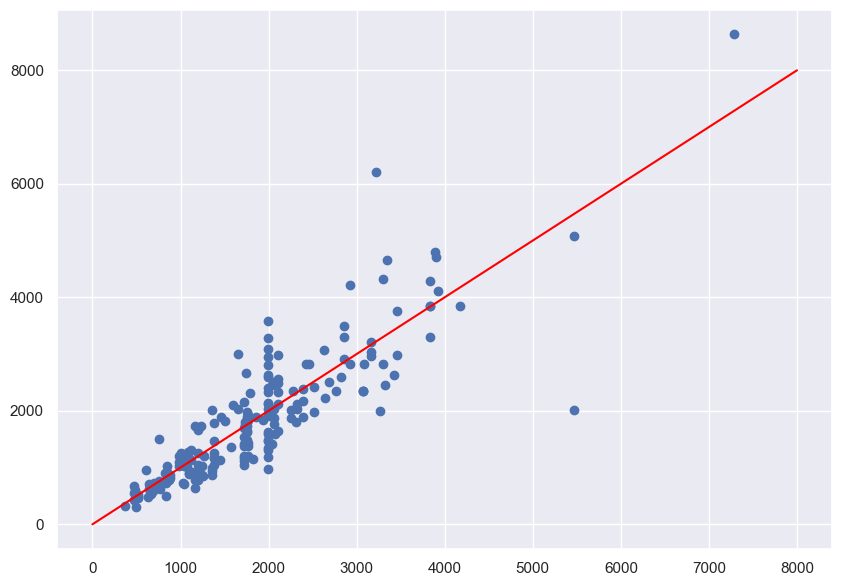

In [6]:
#conda install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


#x is going to be everything except the price. y is the price 
X, y = laptop_data_clean_selectedattributes.drop("Price_sgd", axis=1), laptop_data_clean_selectedattributes["Price_sgd"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 0)

scaler = StandardScaler()

#because we need to fit the scalar on the data and then transform the data to get the data
X_train_scaled = scaler.fit_transform(X_train)
#the test datas are already ditted on to the training data so dont need to fit
X_test_scaled = scaler.transform(X_test) 


forest_laptopdata = RandomForestRegressor(n_estimators=100,random_state=1,max_samples=0.5,max_features=0.75,max_depth=10, n_jobs = 2)

forest_laptopdata.fit(X_train_scaled, y_train)

y_pred = forest_laptopdata.predict(X_test_scaled) #Predicted salary

X_new_scaled = scaler.transform([X_test.iloc[1]])
print("Predicted price for 2nd row: ", forest_laptopdata.predict(X_new_scaled))
print("Actual price: ", y_test.iloc[1])
print("")
print('R2_Score',r2_score(y_test,y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("")

#Scatter graph
plt.figure(figsize=(10, 7))
plt.scatter(y_pred, y_test) #x-axis: predicted, y-axis: actual result
plt.plot(range(0, 8000), range(0, 8000), c="red")

# Forest regression using all the attributes
> Attributes: Company, Product, Inches, ScreenResolution, Cpu, Ram, Memory, Gpu, OpSys, Weight and Price_sgd

In [7]:
# Taking only the selected attributes
laptop_data_clean_selectedattributes = laptop_data_clean[["Company", "Product", "TypeName", "ScreenResolution", "Cpu", "Memory", "Gpu", "OpSys", "Weight","Price_sgd"]].copy()
print(laptop_data_clean_selectedattributes.dtypes)

Company               int32
Product               int32
TypeName              int32
ScreenResolution      int32
Cpu                   int32
Memory                int32
Gpu                   int32
OpSys                 int32
Weight              float64
Price_sgd           float64
dtype: object


Predicted price for 2nd row:  [3366.59638558]
Actual price:  4659.76

R2_Score 0.7927887250243466
Mean Squared Error (MSE): 275348.54264469544



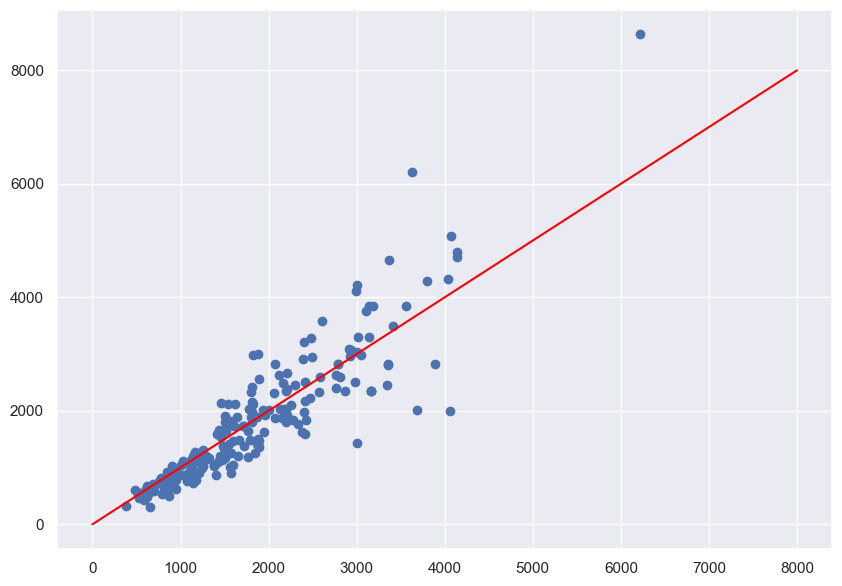

In [8]:
#conda install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


#x is going to be everything except the price. y is the price 
X, y = laptop_data_clean_selectedattributes.drop("Price_sgd", axis=1), laptop_data_clean_selectedattributes["Price_sgd"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 0)

scaler = StandardScaler()

#because we need to fit the scalar on the data and then transform the data to get the data
X_train_scaled = scaler.fit_transform(X_train)
#the test datas are already ditted on to the training data so dont need to fit
X_test_scaled = scaler.transform(X_test) 

forest_laptopdata = RandomForestRegressor(n_estimators=100,random_state=1,max_samples=0.5,max_features=0.75,max_depth=10, n_jobs = 2)

forest_laptopdata.fit(X_train_scaled, y_train)

y_pred = forest_laptopdata.predict(X_test_scaled) #Predicted salary

X_new_scaled = scaler.transform([X_test.iloc[1]])
print("Predicted price for 2nd row: ", forest_laptopdata.predict(X_new_scaled))
print("Actual price: ", y_test.iloc[1])

print("")
print('R2_Score',r2_score(y_test,y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("")
#Scatter graph
plt.figure(figsize=(10, 7))
plt.scatter(y_pred, y_test) #x-axis: predicted, y-axis: actual result
plt.plot(range(0, 8000), range(0, 8000), c="red")

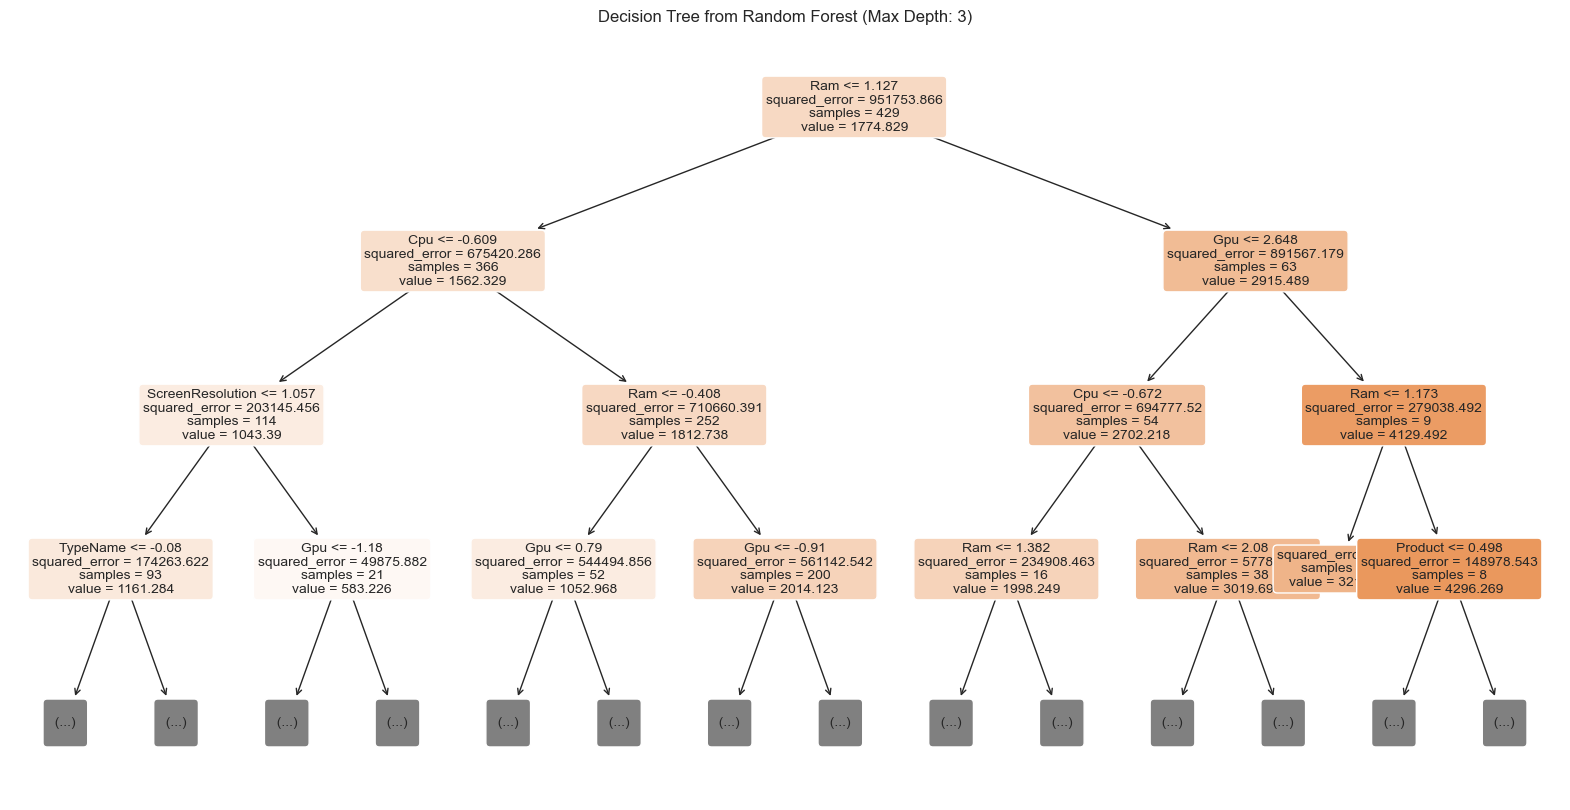

In [9]:
# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest. In here I picked, index 0
tree_to_plot = forest_laptopdata.estimators_[0]

# Define the maximum depth you want to show
max_depth = 3  # Set the maximum depth here

# Plot the decision tree with the specified maximum depth
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=laptop_data_clean.columns.tolist(), filled=True, rounded=True, fontsize=10, max_depth=max_depth)
plt.title("Decision Tree from Random Forest (Max Depth: {})".format(max_depth))
plt.show()

# Analysis
> Using 4 attributes: MSE = 321396.33, Actual = 4659.76, Predicted = 3344.92

> Using all attributes: MSE = 275348.54, Actual = 4659.76, Predicted = 3366.60

### Comparing the two Random Forest Regression, using all the attributes helped me predict the price better. Hence, even though the the top 4 attributes had the most correlation with the price, the other attributes still gave quite a positive impact on predicting the price.

### Furthermore, comparing my mse to the linear regression, my MSE using the Random Forest Regression is significantly lower, creating a prediction that is closer to the actual price. Random Forest Regression is better because:
>  linear regression assumes that there is a linear relationship when it is not always the case. On the other hand, Random Linear can handle complicated non-linear correlations predictor and response variable.

>Random Forest regression uses multiple decision trees (calculated by averaging or combining the predictions from several trees), which makes it less sensitive to outliers compared to the linear regression and decreases overfitting